Example: Explainability LIME plots for MetaLearners
====================================================

Motivation
----------

LIME -- short for *local interpretable model-agnostic explanations* -- is a method developed by [Ribeiro et al. (2016)](https://arxiv.org/abs/1602.04938).
LIME falls under the umbrella term of explainability methods in Machine Learning. On a high level,
it is meant to serve the purpose of providing explanations, intuitions
or examples as to how a model or estimator works.

The authors argue that

> If the users do not trust a model or prediction, they will not use it.

While LIME is typically used in supervised learning scenarios, the key
motivation of better understanding a model's behaviour applies just as
well to CATE estimation. Therefore, we illustrate how it can be used
with the MetaLearner from ``metalearners``.

Background
----------

As the name suggests, LIME is model-agnostic and can be used for any
black-box model which receives features or covariates and maps those
to a one-dimension vector of equal number of rows.

As the name also suggests, the explanations provided by LIME are
local. The authors state the following:

> [...] for an explanation to be meaningful it must at least be locally faithful, i.e. must correspond to how the model behaves in the vicinity of the instance being predicted.

Concretely, this means that LIME focuses on one sample -- or its
locality/vicinity/neighborhood -- at a time and tries to imitate the
true model behaviour around that sample with a simpler model.

In other words, LIME's objective is to choose a substitute model for
our complex model, simulaneously considering two concerns:

* the interpretability of our new, simple model (let's call this surrogate)
* the approximation error between the surrogate and the original,
  complex model

More formally, the authors define:

* $f$, the original model -- in our case the MetaLearner
* $G$, the class of possible, interpretable surrogate models
* $\Omega(g)$, a measure of complexity for $g \in G$
* $\pi_x(z)$ a proximity measure of an instance $z$ with respect to data point $x$
* $\mathcal{L}(f, g, \pi_x)$ a measure of how unfaithful a $g \in G$ is to $f$ in the locality defined by $\pi_x$

Given all of these objects as well as a to be explained data point $x$, the authors suggest that the most appropriate surrogate $g$, also referred to as explanation for $x$, $\xi(x)$, can be expressed as follows:

$$
  \xi(x) = argmin_{g' \in G} \mathcal{L}(f, g', \pi_x) + \Omega(g')
$$

The authors suggest a mechanisms to optimize this problem, i.e. to
find suitable local explanations.

Moreover, they suggest a systematic approach to selecting a set of samples, as for
their respective local explanations to be as telling of the overall model
behaviour as possible. Intuitively, the authors suggest to select a pool of explanations which

* have little redundancy between each other
* showcase the features with highest global importance

In line with this ambition, they define a notion of 'coverage' which specifies how well a set
of candidate datapoints $V$ are explained by features that are relevant for
many observed datapoints. The goal is to find $V$ that is not larger than some
pre-specified size such that this coverage is maximal.

$$
  c(V, W, \mathcal{I}) = \sum_{j=1}^{d} \mathbb{I}\{\exists i \in V: W_{i,j} > 0\} \mathcal{I}_j
$$

where

* $d$ is the number of features
* $V$ is the candidate set of explanations to be shown to
  humans, within a fixed budget -- this is the variable to be optimized
* $W$ is a $n \times d$ local feature importance matrix that represents
  the local importance of each feature for each instance, and
* $\mathcal{I}$ is a $d$-dimensional vector of global
  feature importances

Implicitly, the authors suppose that local model $\xi(x_i)$ has a
canonical way of determining feature importances for $W$ --
e.g. weights in a linear model --
and that a global model $f$ does so, too, for
$\mathcal{I}$.

Picking data points to optimize this notion of coverage is reflected
in ``lime``'s ``SubmodularPick`` class, which we use below.

Installation
------------

In order to generate LIME plots, we first need to install the [lime package](https://github.com/marcotcr/lime).
We can do so either via conda and conda-forge:

```console
$ conda install lime -c conda-forge
```

or via pip and PyPI

```console
$ pip install lime
```

Usage
-----

### Loading the data

Just like in our [example on estimating CATEs with a MetaLearner](../example_basic/), we will first load some experiment data:

In [1]:
import pandas as pd
from pathlib import Path
from git_root import git_root

df = pd.read_csv(git_root("data/learning_mindset.zip"))
outcome_column = "achievement_score"
treatment_column = "intervention"
feature_columns = [
    column
    for column in df.columns
    if column not in [outcome_column, treatment_column]
]
categorical_feature_columns = [
    "ethnicity",
    "gender",
    "frst_in_family",
    "school_urbanicity",
    "schoolid",
]
# Note that explicitly setting the dtype of these features to category
# allows both lightgbm as well as shap plots to
# 1. Operate on features which are not of type int, bool or float
# 2. Correctly interpret categoricals with int values to be
#    interpreted as categoricals, as compared to ordinals/numericals.
for categorical_feature_column in categorical_feature_columns:
    df[categorical_feature_column] = df[categorical_feature_column].astype(
        "category"
    )

Now that we've loaded the experiment data, we can train a MetaLearner.


### Training a MetaLearner

Again, mirroring our [example on estimating CATEs with a MetaLearner](../example_basic/), we can train an
`RLearner` as follows:

In [2]:
from metalearners import RLearner
from lightgbm import LGBMRegressor, LGBMClassifier

rlearner = RLearner(
    nuisance_model_factory=LGBMRegressor,
    propensity_model_factory=LGBMClassifier,
    treatment_model_factory=LGBMRegressor,
    is_classification=False,
    n_variants=2,
    nuisance_model_params={"verbose": -1},
    propensity_model_params={"verbose": -1},
    treatment_model_params={"verbose": -1},
)

rlearner.fit(
    X=df[feature_columns],
    y=df[outcome_column],
    w=df[treatment_column],
)

### Generating lime plots

``lime`` will expect a function which consumes a ``np.ndarray`` ``X`` and returns
a one-dimensional vector of the same length as ``X``. We'll have to
adapt the <a href="../../api_documentation/#metalearners.TLearner.predict"><code>predict</code></a> method of
our `RLearner` in three ways:

* We need to pass a value for the necessary parameter ``is_oos`` to `predict`

* We need to reshape the output of `predict` to be one-dimensional. This
  we can easily achieve via <a href="../../api_documentation/#metalearners.utils.simplify_output"><code>simplify_output</code></a>.

* We need to reconvert the ``np.ndarray`` to a ``pd.DataFrame`` to work with categoricals
  and specify the correct categories so the categorical codes are the same (which are used internally in LightGBM),
  see [this issue](https://github.com/microsoft/LightGBM/issues/5162) for more context.

This we can do as follows:

In [3]:
from metalearners.utils import simplify_output

def predict(X):
    X_pd = pd.DataFrame(X, copy=True)
    for c in X_pd.columns:
        # This line sets the cat.categories correctly (even if not all are present in X)
        X_pd[c] = X_pd[c].astype(df[feature_columns].iloc[:, c].dtype)
    return simplify_output(rlearner.predict(X_pd, is_oos=True))

where we set ``is_oos=True`` since ``lime`` will call
<a href="../../api_documentation/#metalearners.RLearner.predict"><code>predict</code></a>
with various inputs which will not be able to be recognized as
in-sample data.

Moreover, we need to manually prepare the mapping of categorical codes
to categorical values as well as the indices of categorical features:

In [4]:
categorical_names: list[list] = []
for i, column in enumerate(feature_columns):
    categorical_names.append([])
    if column in categorical_feature_columns:
        categorical_names[i] = list(df[column].cat.categories)

categorical_feature_indices = [
    i for i, name in enumerate(feature_columns) if name in categorical_feature_columns
]

We can now create the necessary ``lime`` objects:
``LimeTabularExplainer`` to explain a sample at hand as
well as ``SubmodularPick``, choosing samples for us to be
locally explained.

In the following we can see the three explanations which have been chosen. We find the
most locally most relevant features on the vertical axis and the
outcome dimension on the horizontal axis.

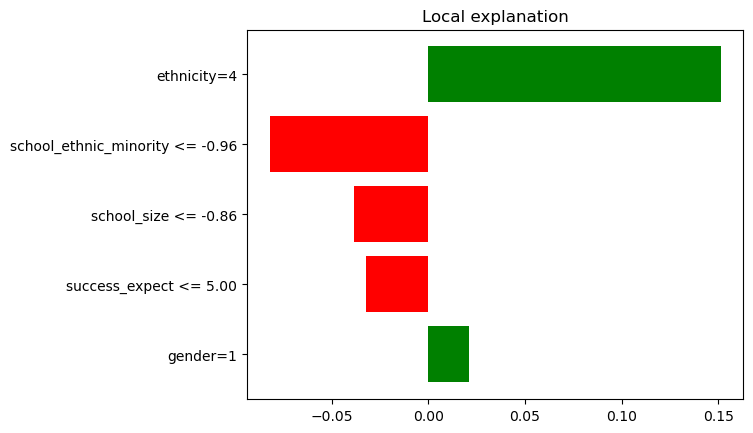

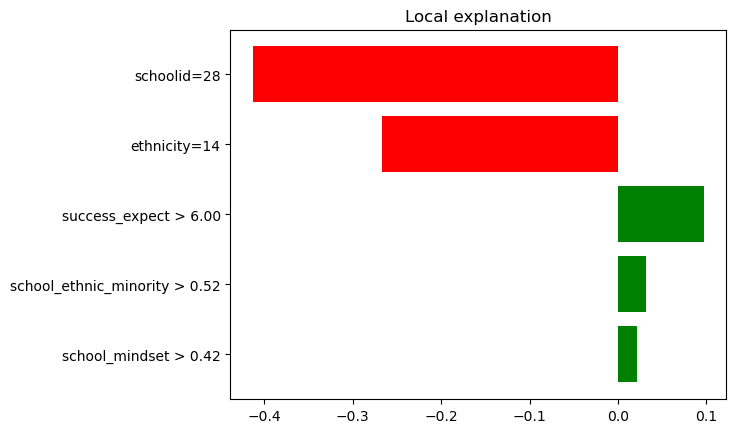

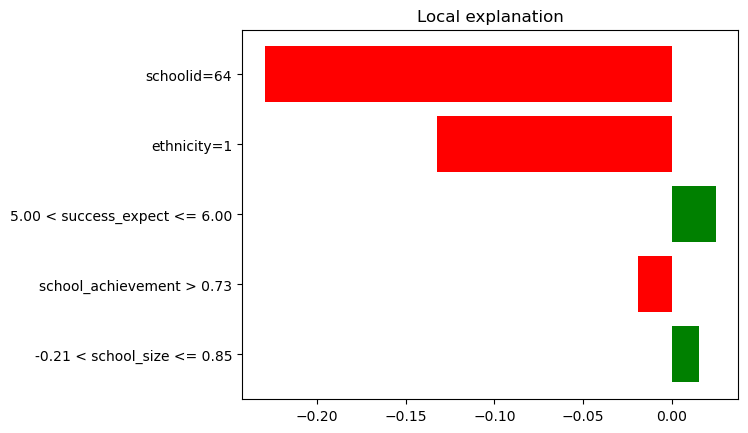

In [5]:
from lime.lime_tabular import LimeTabularExplainer
from lime.submodular_pick import SubmodularPick

explainer = LimeTabularExplainer(
    df[feature_columns].to_numpy(),
    feature_names=feature_columns,
    categorical_features=categorical_feature_indices,
    categorical_names=categorical_names,
    verbose=False,
    mode="regression",
    discretize_continuous=True,
)

sp = SubmodularPick(
    data=df[feature_columns].to_numpy(),
    explainer=explainer,
    predict_fn=predict,
    method="sample",
    sample_size=1_000,
    num_exps_desired=3,
    num_features=5,
)

for explanation in sp.sp_explanations:
    explanation.as_pyplot_figure()

In these plots, the green bars signify that the presence of the corresponding feature
referenced on the y-axis, increases the CATE estimate for that observation, whereas, the
red bars represent that the feature presence in the observation reduces the CATE.
Furthermore, the length of these colored bars corresponds to the magnitude of each feature's
contribution towards the model prediction. Therefore, the longer the bar, the more
significant the impact of that feature on the model prediction.

For more guidelines on how to interpret such lime plots please see the [lime documentation](https://github.com/marcotcr/lime).